In [1]:
import sys
sys.path.append('/Users/jakehirst/Desktop/sfx/sfx_ML_code/sfx_ML/New_Models')

from RF_fed_GPR import *
from NN_fed_GPR import *
from GPR import *
from Single_UQ_models import *

all_labels = ['height', 'phi', 'theta', 
                            'impact site x', 'impact site y', 'impact site z', 
                            'impact site r', 'impact site phi', 'impact site theta']

model_types = ['Single GPR', 'NN_fed_GPR', 'RF_fed_GPR']

model_types = ['NN_fed_GPR']

labels_to_predict = ['impact site x', 'impact site y', 'height']
labels_to_predict = ['impact site y']

with_or_without_transformations = 'with'
with_or_without_transformations = 'without'

Paper2_path = f'/Volumes/Jake_ssd/Paper 2/{with_or_without_transformations}_transformations_trial_2'
Paper2_path = f'/Volumes/Jake_ssd/Paper 2/{with_or_without_transformations}_transformations_trial_2'

model_folder = Paper2_path + f'/UQ_bagging_models_{with_or_without_transformations}_transformations'
data_folder = Paper2_path + '/5fold_datasets'
results_folder = Paper2_path + '/Compare_Code_5_fold_ensemble_results'
hyperparam_folder = Paper2_path + f'/bayesian_optimization_{with_or_without_transformations}_transformations'

image_folder = '/Users/jakehirst/Desktop/sfx/sfx_ML_data/images_sfx/new_dataset/Visible_cracks'

if(with_or_without_transformations == 'with'):
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/dataset/feature_transformations_2023-11-16/height/HEIGHTALL_TRANSFORMED_FEATURES.csv"
    backward_feat_selection_results_folder = '/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/results'
else:
    # full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_no_feature_engineering/dataset/New_Crack_Len_FULL_OG_dataframe_2023_11_16.csv"
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 2/New_Crack_Len_FULL_OG_dataframe_2024_02_22.csv"
    backward_feat_selection_results_folder = Paper2_path + '/Paper_2_results_WITHOUT_feature_engineering/results' 
    df = pd.read_csv(full_dataset_pathname, index_col=0)
    all_features = df.columns
    all_features = all_features.drop(all_labels)
    all_features = str(all_features.drop('timestep_init').to_list())

    print(all_features)

['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'median_kink', 'std_kink', 'var_kink', 'avg_ori', 'angle_btw']


# Aleatoric and Epistemic uncertainties can be easily calculated with the GPR uncertainties:

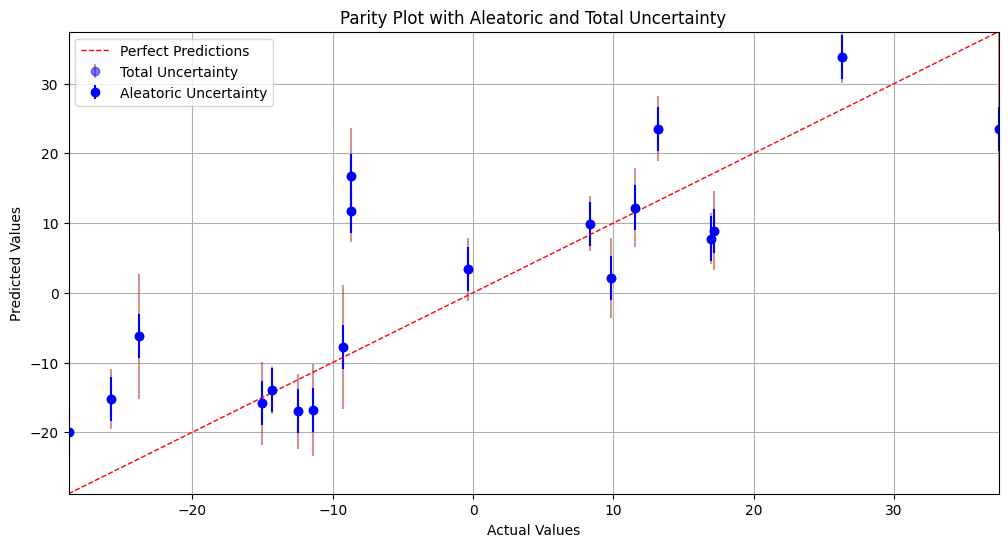

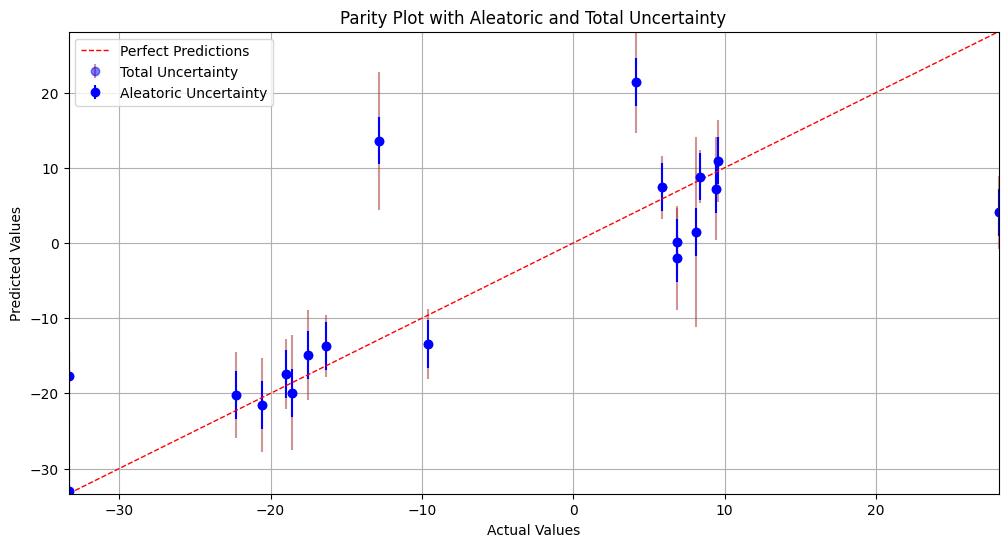

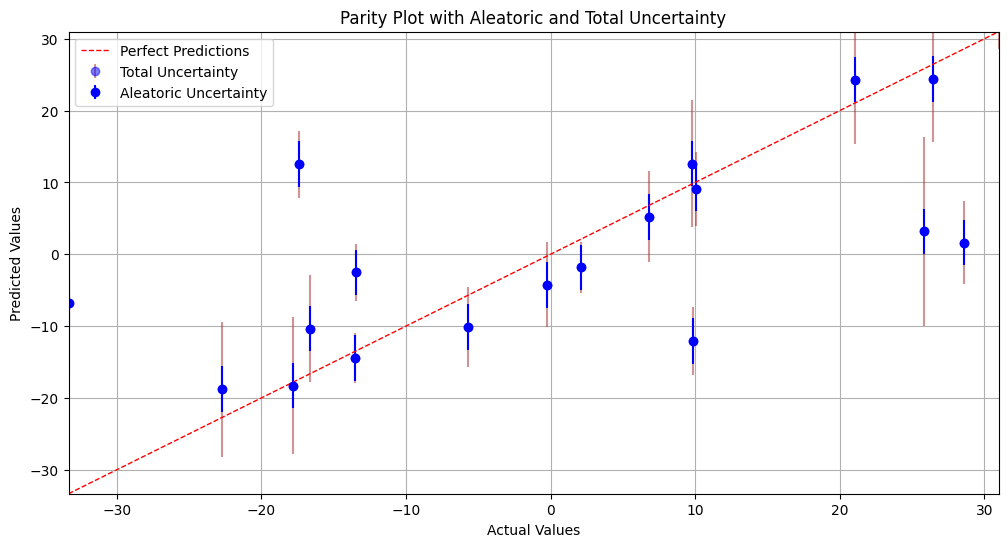

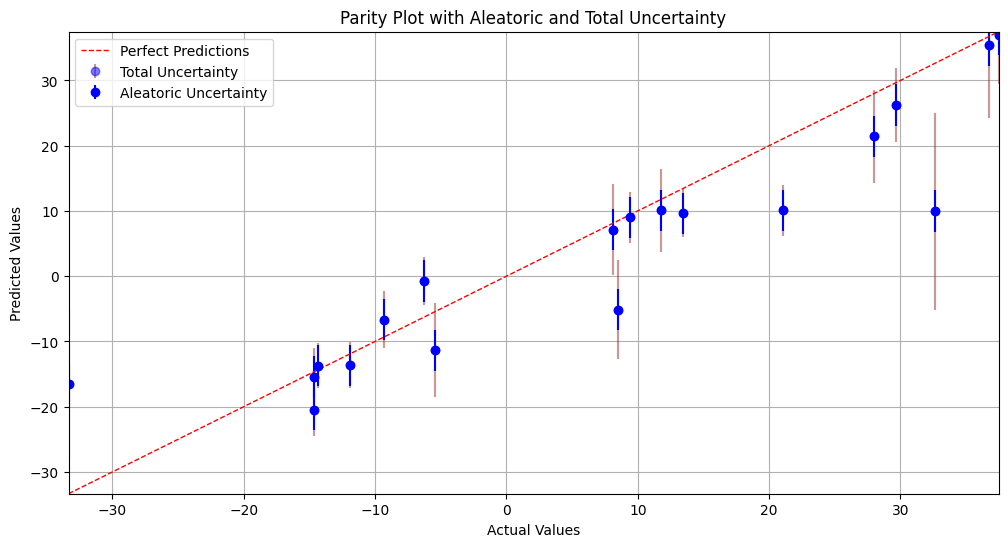

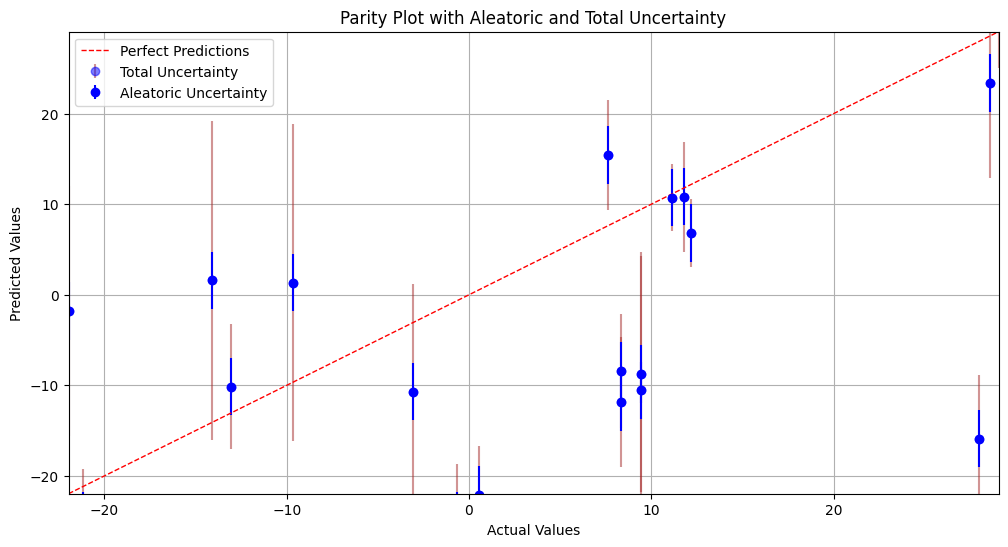

here


In [8]:
def plot_error_bars_aleatoric_and_epistemic(true_vals, predictions, total_uncertainty, aleatoric_uncertainty):
     # Create the parity plot with error bars for total and aleatoric uncertainty
    plt.figure(figsize=(12, 6))

    # Total uncertainty error bars
    plt.errorbar(true_vals, predictions, yerr=total_uncertainty,color='blue', fmt='o', ecolor='brown', alpha=.5, label='Total Uncertainty')

    # Aleatoric uncertainty error bars
    plt.errorbar(true_vals, predictions, yerr=aleatoric_uncertainty, color='blue', fmt='o', ecolor='blue', alpha=1, label='Aleatoric Uncertainty')

    # Plot the line of perfect predictions for reference
    plt.plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], '--',c='red', lw=1, label='Perfect Predictions')

    plt.xlim((true_vals.min(), true_vals.max()))
    plt.ylim((true_vals.min(), true_vals.max()))
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Parity Plot with Aleatoric and Total Uncertainty')
    plt.legend()
    plt.grid(True)
    # plt.axis('equal')
    plt.show()
    return


'''plots the ratio of the amount of aleatoric/total uncertainty.'''
def plot_uncertainty_ratios(ratios, label_to_predict):
    # Preparing data for bar plots with error bars
    means = {key: np.mean(values) for key, values in ratios.items()}
    stddevs = {key: np.std(values) for key, values in ratios.items()}

    # X locations for the groups
    ind = np.arange(len(ratios))
    width = 0.35  # the width of the bars

    # Creating bar plots with error bars
    fig, ax = plt.subplots(figsize=(6, 6))

    # Bar plot
    if(label_to_predict == 'impact site x'):
        ax.bar(means.keys(), means.values(), color='blue', yerr=stddevs.values(), align='center', alpha=0.7, ecolor='black', capsize=10)
    elif(label_to_predict == 'impact site y'):
        ax.bar(means.keys(), means.values(), color='red', yerr=stddevs.values(), align='center', alpha=0.7, ecolor='black', capsize=10)
    else:
        ax.bar(means.keys(), means.values(), color='green', yerr=stddevs.values(), align='center', alpha=0.7, ecolor='black', capsize=10)

        
    # Labels and titles
    ax.set_ylabel('Aleatoric/total uncertainty', fontsize='large')
    ax.set_xticks(ind)
    ax.set_xticklabels(means.keys(), fontsize='large')
    ax.set_title(f'Bar Plots showing ratio of average aleatoric/total uncertainty \n{label_to_predict.capitalize()}', fontsize='large')
    ax.set_ylim(0,1)
    # Showing the plot
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'/Users/jakehirst/Desktop/sfx/Presentations_and_Papers/Paper 2/Figures/uncertainty_ratios/{label_to_predict}.png')
    plt.close()
    return

for label_to_predict in labels_to_predict:
    # print('\n\n' + label_to_predict)
    ratios = {}
    for model_type in model_types:
        # print(model_type.capitalize() + '\n')
        ratios[model_type] = []
        for fold_no in range(1,6):
            model_path = f'/Volumes/Jake_ssd/Paper 2/without_transformations_trial_2/UQ_bagging_models_without_transformations/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
            model_path = f'/Volumes/Jake_ssd/Paper 2/without_transformations/UQ_bagging_models_without_transformations/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'

            results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
            test_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_features.csv'
            test_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_labels.csv'
            test_r2, test_ensemble_predictions, test_ensemble_uncertanties, test_labels = Get_predictions_and_uncertainty_single_model(test_features_path, test_labels_path, model_path, results_saving_folder, ast.literal_eval(all_features), label_to_predict, model_type)

        
            model = load_GPR_model(model_path + '/model_no1.sav')
            #The aleatoric uncerrtainty is ASSUMED to be constant across all inputs with the way that the GPR is set up, and can be represented as the sqrt of the noise level of the white noise kernel.
            #We take the sqrt because the noise_level is represented as a variance. So if you want to get the standard deviation, you need to square root it.
            if(model_type == 'Single GPR'):
                # print(model.get_params()['kernel']) 
                # print(model.kernel_)
                white_noise = model.kernel_.k2.noise_level
            else:
                homoscedastic_aleatoric_uncertainty = np.sqrt(model.gpr.get_params()['kernel__k2__noise_level'])
                # print(model.gpr.get_params()['kernel'])
                # print(model.gpr.kernel_) #COMMENT model.kernel is the initiated kernel, whereas model.kernel_ is the optimized kernel!! this took so long to figure out...
                white_noise = model.gpr.kernel_.k2.noise_level
                
                

            #Aleatoric uncertainty (constant, from WhiteKernel)
            aleatoric_uncertainty = np.sqrt(white_noise)

            # Total uncertainty is the predictive standard deviation from the GP
            total_uncertainties = test_ensemble_uncertanties / 2 #divide by two 
            
            epistemic_uncertainties = total_uncertainties - aleatoric_uncertainty
            
            ratio = (aleatoric_uncertainty) / np.mean(total_uncertainties) 
            # print(f'*** RATIO = {ratio} ***')
            ratios[model_type].append(ratio)

            '''plotting aleatoric and total uncertainties'''
            plot_error_bars_aleatoric_and_epistemic(test_labels[1:20], test_ensemble_predictions[1:20], total_uncertainties[1:20], aleatoric_uncertainty)
            # # Create the parity plot with error bars for total and aleatoric uncertainty
            # plt.figure(figsize=(12, 6))

            # # Total uncertainty error bars
            # plt.errorbar(test_labels, test_ensemble_predictions, yerr=total_uncertainties, fmt='o', ecolor='gray', alpha=1, capsize=5, label='Total Uncertainty')

            # # Aleatoric uncertainty error bars
            # plt.errorbar(test_labels, test_ensemble_predictions, yerr=aleatoric_uncertainty, fmt='o', ecolor='blue', alpha=0.9, capsize=3, label='Aleatoric Uncertainty')

            # # Plot the line of perfect predictions for reference
            # plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], c='r', lw=1, label='Perfect Predictions')

            # plt.xlim((test_labels.to_numpy().min(), test_labels.to_numpy().max()))
            # plt.ylim((test_labels.to_numpy().min(), test_labels.to_numpy().max()))
            # plt.xlabel('Actual Values')
            # plt.ylabel('Predicted Values')
            # plt.title('Parity Plot with Aleatoric and Total Uncertainty')
            # plt.legend()
            # plt.grid(True)
            # # plt.axis('equal')
            # plt.show()
    plot_uncertainty_ratios(ratios, label_to_predict)

            
# model_path = f'/Volumes/Jake_ssd/Paper 2/without_transformations_trial_2/UQ_bagging_models_without_transformations/impact site x/Single GPR/1_models/fold_1/model_no1.sav'
# model = load_GPR_model(model_path)
# print(model.get_params())
# print(model.get_params()['kernel']) 

# model_path = f'/Volumes/Jake_ssd/Paper 2/without_transformations_trial_2/UQ_bagging_models_without_transformations/impact site y/Single GPR/1_models/fold_1/model_no1.sav'
# model = load_GPR_model(model_path)
# print(model.get_params())
# print(model.get_params()['kernel']) 

# model_path = f'/Volumes/Jake_ssd/Paper 2/without_transformations_trial_2/UQ_bagging_models_without_transformations/height/Single GPR/1_models/fold_1/model_no1.sav'
# model = load_GPR_model(model_path)
# print(model.get_params())
# print(model.get_params()['kernel']) 

# print(model.gpr.get_params()) 
# print(model.gpr.get_params()['kernel'])   
            


print('here')